<a href="https://colab.research.google.com/github/yair11/Regression-problem/blob/master/project5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip -q install kaggle
!pip -q install osmnx
!pip -q install holidays

In [ ]:
!pip -q install matplotlib==3.1.3

     |████████████████████████████████| 13.1 MB 5.0 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
osmnx 1.1.2 requires matplotlib>=3.4, but you have matplotlib 3.1.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [ ]:
import pandas as pd
import osmnx as ox
import networkx as nx
from datetime import timedelta
import matplotlib.pyplot as plt
import datetime
import holidays
import seaborn as sns
import ast
import numpy as np

from sklearn.cluster import KMeans


import warnings
warnings.filterwarnings("ignore")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

###Getting the data

In [ ]:
!kaggle config set -n path -v{/content}

- path is now set to: {/content}


In [ ]:
!cp /content/kaggle.json ~/.kaggle/kaggle.json

In [ ]:
!kaggle config set -n path -v{/content}

- path is now set to: {/content}


In [ ]:
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c new-york-city-taxi-fare-prediction

 99% 1.54G/1.56G [00:09<00:00, 211MB/s]
100% 1.56G/1.56G [00:09<00:00, 170MB/s]


In [ ]:
!unzip /content/{/content}/competitions/new-york-city-taxi-fare-prediction/new-york-city-taxi-fare-prediction.zip

Archive:  /content/{/content}/competitions/new-york-city-taxi-fare-prediction/new-york-city-taxi-fare-prediction.zip
  inflating: GCP-Coupons-Instructions.rtf  
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               

In [ ]:
!rm /content/GCP-Coupons-Instructions.rtf
!rm /content/test.csv
!rm /content/sample_submission.csv

In [ ]:
NUMNER_OF_ROWS = 2000000
taxi_travels = pd.read_csv('/content/train.csv', nrows=NUMNER_OF_ROWS)

# Cleaning the data

## Cleaning NULL

In [ ]:
taxi_travels.dropna(inplace=True)
taxi_travels.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,1.999986e+06,1.999986e+06,1.999986e+06,1.999986e+06,1.999986e+06,1.999986e+06
mean,1.134768e+01,-7.252324e+01,3.992965e+01,-7.252395e+01,3.992808e+01,1.684125e+00
std,9.852609e+00,1.286798e+01,7.983330e+00,1.277497e+01,1.032382e+01,1.314979e+00
min,-6.200000e+01,-3.377681e+03,-3.458665e+03,-3.383297e+03,-3.461541e+03,0.000000e+00
25%,6.000000e+00,-7.399208e+01,4.073491e+01,-7.399141e+01,4.073400e+01,1.000000e+00
50%,8.500000e+00,-7.398181e+01,4.075263e+01,-7.398016e+01,4.075312e+01,1.000000e+00
75%,1.250000e+01,-7.396713e+01,4.076710e+01,-7.396369e+01,4.076809e+01,2.000000e+00
max,1.273310e+03,2.856442e+03,2.621628e+03,3.414307e+03,3.345917e+03,2.080000e+02


We can see that we have a lot garbage in the data (like negative fare_amount and ext)

## Cleaning fare_amount column

In [ ]:
# Minimum (start) price per trip
taxi_travels = taxi_travels[taxi_travels.fare_amount>2.5]

##Cleaning rides without passengers

In [ ]:
taxi_travels = taxi_travels.loc[(taxi_travels.passenger_count>0) & (taxi_travels.passenger_count<7)]

## Checking dates validity

In [ ]:
def is_date_valid(date):
  year, month, day = date.split('-')
  try:
      datetime.datetime(int(year), int(month), int(day))
      return True
  except ValueError:
      return False

taxi_travels['dates'] = taxi_travels.pickup_datetime.str[:10]
taxi_travels['is_date_valid'] = taxi_travels['dates'].apply(lambda x: is_date_valid(x))
print(taxi_travels.is_date_valid.value_counts())
taxi_travels = taxi_travels.drop('is_date_valid', axis=1)

True    1984499
Name: is_date_valid, dtype: int64


## Cleaning pickup_longitude, pickup_latitud, dropoff_longitude, dropoff_latitude columns:

In [ ]:
# Deleting all the rows that pickup_longitude = dropoff_longitude & pickup_latitude = dropoff_latitude (56,000 rows)
taxi_travels = taxi_travels[~((taxi_travels.pickup_longitude == taxi_travels.dropoff_longitude)\
             & (taxi_travels.pickup_latitude == taxi_travels.dropoff_latitude))]

In [ ]:
#Cleaning latitude points
print(taxi_travels[['pickup_latitude', 'dropoff_latitude']].max())
print(taxi_travels[['pickup_latitude', 'dropoff_latitude']].min())


#The latitude of new york is 	40.730610 so we can see that we have a lot of garbage
taxi_travels = taxi_travels.loc[(taxi_travels.pickup_latitude > 40.5) & (taxi_travels.pickup_latitude > 40.5)\
                                & (taxi_travels.pickup_latitude <41) & (taxi_travels.pickup_latitude < 41 )]
print(taxi_travels[['pickup_latitude', 'pickup_latitude']].max())
print(taxi_travels[['pickup_latitude', 'pickup_latitude']].min())
taxi_travels.shape


pickup_latitude     2621.628430
dropoff_latitude    3345.917353
dtype: float64
pickup_latitude    -3458.664702
dropoff_latitude   -3461.540872
dtype: float64
pickup_latitude    40.999287
pickup_latitude    40.999287
dtype: float64
pickup_latitude    40.500408
pickup_latitude    40.500408
dtype: float64


(1926304, 9)

In [ ]:
#Cleaning longitude points
print(taxi_travels[['pickup_longitude', 'dropoff_longitude']].max())
print(taxi_travels[['pickup_longitude', 'dropoff_longitude']].min())
#The longitude of new york is -73.935242 so we can see that we have a lot of garbage
taxi_travels = taxi_travels.loc[(taxi_travels.pickup_longitude < -72) & (taxi_travels.dropoff_longitude < -72)\
                                & (taxi_travels.pickup_longitude > -74.3) & (taxi_travels.dropoff_longitude > -74.3)]
print(taxi_travels[['pickup_longitude', 'dropoff_longitude']].max())
print(taxi_travels[['pickup_longitude', 'dropoff_longitude']].min())
taxi_travels.shape


pickup_longitude      0.551758
dropoff_longitude    45.581619
dtype: float64
pickup_longitude    -1452.988333
dropoff_longitude   -2125.745368
dtype: float64
pickup_longitude    -72.063202
dropoff_longitude   -72.196091
dtype: float64
pickup_longitude    -74.296772
dropoff_longitude   -74.299730
dtype: float64


(1924192, 9)

## Ploting the lat and long points

(-74.03, -73.75)

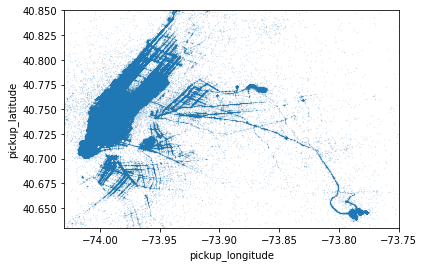

In [ ]:
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)
taxi_travels[['pickup_latitude','pickup_longitude']].plot(kind ='scatter', x='pickup_longitude', y='pickup_latitude',s=.02, alpha =0.4)
plt.ylim(city_lat_border)
plt.xlim(city_long_border)

(-74.03, -73.75)

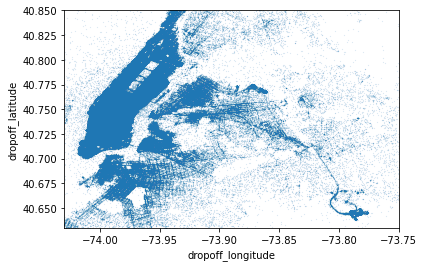

In [ ]:
taxi_travels[['dropoff_latitude','dropoff_longitude']].plot(kind ='scatter', x='dropoff_longitude', y='dropoff_latitude',s=.02, alpha =0.4)
plt.ylim(city_lat_border)
plt.xlim(city_long_border)

The plot of the pickup data and dropoff shows that we have a map simular to NYC:

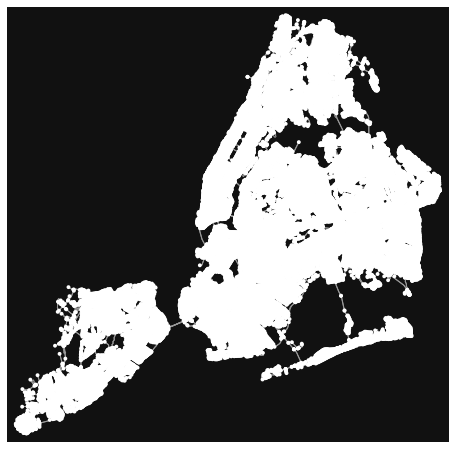

we can note that there are 2 particular places with high pickup density:

1. JFK airport
2. LA Gurdia airport

## Clustering

Text(0, 0.5, 'Inertia')

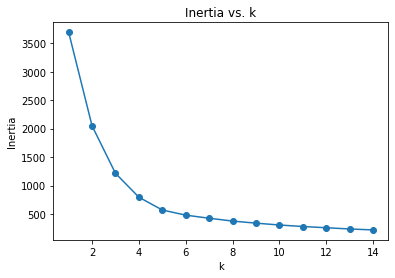

In [ ]:
def calc_inertia(k,data):
    model = KMeans(n_clusters=k).fit(data)
    return model.inertia_

data = taxi_travels[['pickup_longitude','pickup_latitude']]

inertias = [(k, calc_inertia(k,data)) for k in range(1, 15)]

plt.plot(*zip(*inertias), marker='o')
plt.title('Inertia vs. k')
plt.xlabel('k')
plt.ylabel('Inertia')


In [ ]:
X = data
k=4
model = KMeans(n_clusters=k)
data['cluster'] = pd.Series(model.fit_predict(X))
data = data.dropna()
data['cluster'].value_counts(dropna=False)

3.0    914296
1.0    855329
0.0     52003
2.0     29576
Name: cluster, dtype: int64

In [ ]:
colors = {-1:'black', 0: 'blue', 1: 'lightgreen', 2: 'red', 3:'yellow'}

centers_xy = pd.DataFrame(model.cluster_centers_[:, :2],
                          columns=['pickup_longitude', 'pickup_latitude'])
center_color = pd.DataFrame(-1 * np.ones((k, 1)),
                            columns=['cluster'])
center_data = pd.concat((centers_xy, center_color), axis=1)
center_data

,pickup_longitude,pickup_latitude,cluster
0,-73.876873,40.768377,-1.0
1,-73.993510,40.733540,-1.0
2,-73.783860,40.647851,-1.0
3,-73.970739,40.769344,-1.0


In [ ]:
centroids = model.cluster_centers_

(-74.03, -73.75)

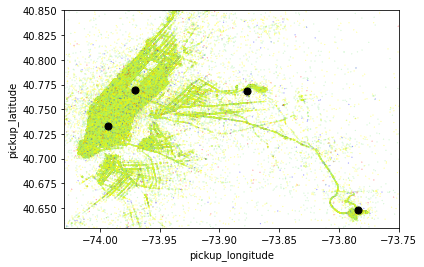

In [ ]:
data_with_centers = pd.concat((data, center_data), axis=0)
c = data_with_centers['cluster'].apply(lambda x: colors[x])
data_with_centers.plot('pickup_longitude', 'pickup_latitude', kind='scatter', c=c, s=.02, alpha =1)
plt.scatter(centroids[:, 0], centroids[:, 1], c='black', s=50)
plt.ylim(city_lat_border)
plt.xlim(city_long_border)

In [ ]:
data = data.drop('cluster',axis=1)

In [ ]:
from sklearn.cluster import DBSCAN
dbs = DBSCAN(eps=0.3, min_samples=7)

In [ ]:
data['cluster'] = dbs.fit_predict(data)

In [ ]:
sns.pairplot(data, hue='cluster')

# Feature Engeneering

### Checking if it's a holiday day or not

In [ ]:
#Checking if it's a holiday day or not
def is_holiday(date, us_holidays):
  if date in us_holidays:
    return 1
  return 0


taxi_travels['dates'] = pd.to_datetime(taxi_travels.pickup_datetime.str[:10])
us_holidays = holidays.US()
taxi_travels['is_holiday'] = taxi_travels['dates'].apply(lambda  x: is_holiday(x, us_holidays))
taxi_travels['is_holiday'].value_counts()

0    93880
1     2264
Name: is_holiday, dtype: int64

### Deviding the day for morning, afternoon, evening, night



In [ ]:
#Deviding the day for morning, afternoon, evening, night
def get_part_of_day(h):
    return (
        "morning"
        if 5 <= h <= 11
        else "afternoon"
        if 12 <= h <= 17
        else "evening"
        if 18 <= h <= 22
        else "night"
    )

taxi_travels['pickup_part_of_day'] = taxi_travels.pickup_datetime.str[11:19]
taxi_travels.pickup_part_of_day = taxi_travels.pickup_part_of_day.apply(lambda x: x.split(':')[0])
taxi_travels.pickup_part_of_day = taxi_travels.pickup_part_of_day.apply(lambda x: get_part_of_day(int(x)))
taxi_travels.pickup_part_of_day.value_counts()

evening      28279
afternoon    27481
morning      24344
night        16040
Name: pickup_part_of_day, dtype: int64

## Airport pickup and dropof

In [ ]:
#nyc_airports coordinates
nyc_airports={'JFK':{'min_lng':-73.835,
                     'min_lat':40.619,
                     'max_lng':-73.740,
                     'max_lat':40.665},

              'LaGuardia':{'min_lng':-73.889,
                          'min_lat':40.766,
                          'max_lng':-73.855,
                          'max_lat':40.793}
                }

In [ ]:
# a function to assign 1 if we have a pick up or drop off from an airport
def Airport(latitude, longitude, airport_name):
    if (latitude>=nyc_airports[airport_name]['min_lat'] and
      latitude<=nyc_airports[airport_name]['max_lat'] and
      longitude>=nyc_airports[airport_name]['min_lng'] and
      longitude<=nyc_airports[airport_name]['max_lng']):
        return 1
    else:
        return 0

In [ ]:
taxi_travels['pick_up_JFK']=taxi_travels.apply(lambda row:Airport(row['pickup_latitude'],row['pickup_longitude'],'JFK'),axis=1)
taxi_travels['dropoff_JFK']=taxi_travels.apply(lambda row:Airport(row['dropoff_latitude'],row['dropoff_longitude'],'JFK'),axis=1)
taxi_travels['pickup_la_guardia']=taxi_travels.apply(lambda row:Airport(row['pickup_latitude'],row['pickup_longitude'],'LaGuardia'),axis=1)
taxi_travels['dropoff_la_guardia']=taxi_travels.apply(lambda row:Airport(row['dropoff_latitude'],row['dropoff_longitude'],'LaGuardia'),axis=1)

In [ ]:
taxi_travels.dropoff_la_guardia.value_counts()

0    94889
1     1255
Name: dropoff_la_guardia, dtype: int64

## Calculating the routs

In [ ]:
#Taking part of the data to calculate the routs
taxi_travels = taxi_travels.sample(n=50000)
taxi_travels = taxi_travels.reset_index()

In [ ]:
# Unit pickup latitude and longitude points
taxi_travels['pickup_latlng'] = list(zip(taxi_travels.pickup_latitude, taxi_travels.pickup_longitude))
# Unit dropoff latitude and longitude points
taxi_travels['dropoff_latlng'] = list(zip(taxi_travels.dropoff_latitude, taxi_travels.dropoff_longitude))
taxi_travels = taxi_travels.drop(['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude'],axis=1)


In [ ]:
def getting_city_graph(place, mode):
  ox.config(log_console=True, use_cache=True)
  # create graph from OSM within the boundaries of some
  # geocodable place(s)
  graph = ox.graph_from_place(place, network_type=mode, simplify=True)
  return graph

# Finding the shortest rout between two coordinates
def finding_shortest_route(graph, pickup_latlng, dropoff_latlng, mode, optimizer):
  try:
    # find the nearest node to the start location
    orig_node = ox.get_nearest_node(graph, pickup_latlng)
    # find the nearest node to the end location
    dest_node = ox.get_nearest_node(graph, dropoff_latlng)
    #  find the shortest path
    shortest_route = nx.shortest_path(graph,
                                    orig_node,
                                    dest_node,
                                    weight=optimizer)

    return shortest_route
  except:
    print(0)

def getting_streets_names(shortest_route):
  list_of_streets = []
  for previous, current in zip(shortest_route, shortest_route[1:]):
    try:
      list_of_streets.append(graph.edges[(previous, current, 0)]["name"])
    except:
      pass
  return list(set(list_of_streets))

In [ ]:
# location where we want to find our route
place = 'New York City, New York, USA'
# find shortest route based on the mode of travel
mode = 'drive' # 'drive', 'bike', 'walk'
# find shortest path based on distance or time
optimizer = 'length'  # 'length','time'

graph = getting_city_graph(place, mode)

In [ ]:
taxi_travels.to_csv('/content/drive/MyDrive/Colab Notebooks/Project5/taxi_travels.csv')
taxi_travels = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Project5/taxi_travels.csv')

def convert_tuple(x):
  lst = x.split(',')
  lat = float(lst[0].replace('(',''))
  lon = float(lst[1].replace(')',''))
  coor = (lat,lon)
  return coor
taxi_travels['pickup_latlng'] = taxi_travels['pickup_latlng'].apply(lambda x:convert_tuple(x))
taxi_travels['dropoff_latlng'] = taxi_travels['dropoff_latlng'].apply(lambda x:convert_tuple(x))


In [ ]:
# Because it's taking a lot of time we using part of the data every iterate
for count, rows in enumerate([(0,10000),(10000,20000),(20000,30000),(30000,40000),(40000,50000)]):
  print(rows)
  start = rows[0]
  end = rows[1]
  part_taxi_travels = taxi_travels.iloc[start:end,:]
  part_taxi_travels['shortest_route'] = part_taxi_travels.apply(lambda x: finding_shortest_route\
                                                 (graph, x['pickup_latlng'], x['dropoff_latlng'], mode, optimizer), axis=1)
  part_taxi_travels.to_csv(f'/content/drive/MyDrive/Colab Notebooks/Project5/taxi_travels{count+1}.csv')



In [ ]:
taxi_travels1 = pd.read_csv(f'/content/drive/MyDrive/Colab Notebooks/Project5/taxi_travels1.csv').drop(columns=['Unnamed: 0'],axis=1)
taxi_travels2 = pd.read_csv(f'/content/drive/MyDrive/Colab Notebooks/Project5/taxi_travels2.csv').drop(columns=['Unnamed: 0.1','Unnamed: 0'],axis=1)
taxi_travels3 = pd.read_csv(f'/content/drive/MyDrive/Colab Notebooks/Project5/taxi_travels3.csv').drop(columns=['Unnamed: 0.1','Unnamed: 0'],axis=1)
taxi_travels4 = pd.read_csv(f'/content/drive/MyDrive/Colab Notebooks/Project5/taxi_travels4.csv').drop(columns=['Unnamed: 0.1','Unnamed: 0'],axis=1)
taxi_travels = pd.concat([taxi_travels1,taxi_travels2,taxi_travels3,taxi_travels4], ignore_index=True)
taxi_travels.info()
taxi_travels = taxi_travels.dropna()
taxi_travels.shortest_route = taxi_travels['shortest_route'].apply(lambda x:ast.literal_eval(x))
taxi_travels.index.nunique()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   index               40000 non-null  int64  
 1   key                 40000 non-null  object 
 2   fare_amount         40000 non-null  float64
 3   pickup_datetime     40000 non-null  object 
 4   passenger_count     40000 non-null  int64  
 5   dates               40000 non-null  object 
 6   is_holiday          40000 non-null  int64  
 7   pickup_part_of_day  40000 non-null  object 
 8   pick_up_JFK         40000 non-null  int64  
 9   dropoff_JFK         40000 non-null  int64  
 10  pickup_la_guardia   40000 non-null  int64  
 11  dropoff_la_guardia  40000 non-null  int64  
 12  pickup_latlng       40000 non-null  object 
 13  dropoff_latlng      40000 non-null  object 
 14  shortest_route      39955 non-null  object 
dtypes: float64(1), int64(7), object(7)
memory usage: 4.6+

39955

## Calculating the distances

In [ ]:
def find_dictance(graph,x,optimize):
  try:
    orig_node = x[0]
    dest_node = x[-1]
    distance_in_kilometers = nx.shortest_path_length(graph, orig_node, dest_node, weight=optimizer) / 1000
    return distance_in_kilometers
  except:
    return 0

taxi_travels['distance'] = taxi_travels.apply(lambda x:find_dictance(graph,x['shortest_route'],optimizer), axis=1)
taxi_travels = taxi_travels.loc[taxi_travels.distance != 0]


## Is there a bridge in the route?

In [ ]:
def is_bridge(route):
  is_bridge = False
  for previous, current in zip(route, route[1:]):
    try:
      if (graph.edges[(previous, current, 0)]["bridge"] == 'yes'):
        is_bridge = True
    except:
      pass
  return is_bridge

taxi_travels['is_bridge'] = taxi_travels.apply(lambda x:is_bridge(x['shortest_route']), axis=1)
taxi_travels['is_bridge'].value_counts()

False    31869
True      7938
Name: is_bridge, dtype: int64

## Is there a tunnel in the route?

In [ ]:
def is_tunnel(route):
  is_tunnel = False
  for previous, current in zip(route, route[1:]):
    try:
      if (graph.edges[(previous, current, 0)]["tunnel"] == 'yes'):
        is_tunnel = True
    except:
      pass
  return is_tunnel

taxi_travels['is_tunnel'] = taxi_travels.apply(lambda x:is_tunnel(x['shortest_route']), axis=1)
taxi_travels['is_tunnel'].value_counts()

False    36049
True      3758
Name: is_tunnel, dtype: int64

## Mean lanes in the route

In [ ]:
def mean_lanes(route):
  mean_lanes = []
  for previous, current in zip(route, route[1:]):
    try:
      mean_lanes.append((int((graph.edges[(previous, current, 0)]['lanes']).split()[0])))
    except:
      pass
  return int((sum(mean_lanes)/len(mean_lanes))) if len(mean_lanes)!= 0 else None


taxi_travels['mean_lanes'] = taxi_travels.apply(lambda x:mean_lanes(x['shortest_route']), axis=1)
taxi_travels['mean_lanes'].value_counts(dropna=False)

3.0     18092
2.0     12505
4.0      5052
1.0      1821
5.0      1659
NaN       405
6.0       246
7.0        20
11.0        3
9.0         2
8.0         1
25.0        1
Name: mean_lanes, dtype: int64

## Streets names in the route



In [ ]:
def getting_streets_names(graph,shortest_route):
  set_of_streets = set({})
  for previous, current in zip(shortest_route, shortest_route[1:]):
    try:
      set_of_streets.add(graph.edges[(previous, current, 0)]["name"])
    except:
      pass
  return set_of_streets
taxi_travels['name_of_srteets'] = taxi_travels.apply(lambda x:getting_streets_names(graph,x['shortest_route']), axis=1)

## Mean max speed in the route

In [ ]:
def mean_maxspeed(route):
  mean_maxspeed = []
  for previous, current in zip(route, route[1:]):
    try:
      mean_maxspeed.append((int((graph.edges[(previous, current, 0)]['maxspeed']).split()[0])))
    except:
      pass
  return int((sum(mean_maxspeed)/len(mean_maxspeed))*1.6093) if len(mean_maxspeed)!= 0 else None


taxi_travels['mean_maxspeed_of_srteets'] = taxi_travels.apply(lambda x:mean_maxspeed(x['shortest_route']), axis=1)
taxi_travels['mean_maxspeed_of_srteets'].value_counts(dropna=False)

#writing the final CSV

In [ ]:
taxi_travels = taxi_travels.dropna()
taxi_travels.shape
taxi_travels.to_csv('/content/drive/MyDrive/Colab Notebooks/Project5/taxi_travels_final.csv')

(36641, 21)

#Getting the data

In [ ]:
taxi_travels = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Project5/taxi_travels_final.csv')
taxi_travels = taxi_travels.replace({True:1,False:0})
taxi_travels.shape

(36641, 22)

In [ ]:
taxi_travels.columns

Index(['Unnamed: 0', 'index', 'key', 'fare_amount', 'pickup_datetime',
       'passenger_count', 'dates', 'is_holiday', 'pickup_part_of_day',
       'pick_up_JFK', 'dropoff_JFK', 'pickup_la_guardia', 'dropoff_la_guardia',
       'pickup_latlng', 'dropoff_latlng', 'shortest_route', 'distance',
       'is_bridge', 'is_tunnel', 'mean_lanes', 'name_of_srteets',
       'mean_maxspeed_of_srteets'],
      dtype='object')

In [ ]:
columns = ['fare_amount', 'passenger_count', 'is_holiday', 'pickup_part_of_day', 'pick_up_JFK', 'dropoff_JFK', 'pickup_la_guardia', 'dropoff_la_guardia',\
'distance','is_bridge', 'is_tunnel', 'mean_lanes','mean_maxspeed_of_srteets']

In [ ]:
for col in columns:
  print('Column name:',col)
  print('Column values:','\n',taxi_travels[col].value_counts())
  print('#########################################################################')

# Removing outlyers

In [ ]:
taxi_travels = taxi_travels.loc[taxi_travels.is_holiday == 0]
taxi_travels = taxi_travels.loc[taxi_travels.passenger_count <= 4]
taxi_travels = taxi_travels.loc[taxi_travels.pick_up_JFK == 0]
taxi_travels = taxi_travels.loc[taxi_travels.dropoff_JFK == 0]
taxi_travels = taxi_travels.loc[taxi_travels.pickup_la_guardia == 0]
taxi_travels = taxi_travels.loc[taxi_travels.dropoff_la_guardia == 0]
taxi_travels = taxi_travels.loc[taxi_travels.mean_lanes < 6]
taxi_travels.shape

(30495, 22)

In [ ]:
taxi_travels = taxi_travels[['passenger_count', 'pickup_part_of_day','distance','is_bridge', 'is_tunnel',
                            'mean_lanes','mean_maxspeed_of_srteets', 'fare_amount']]

# Correlation

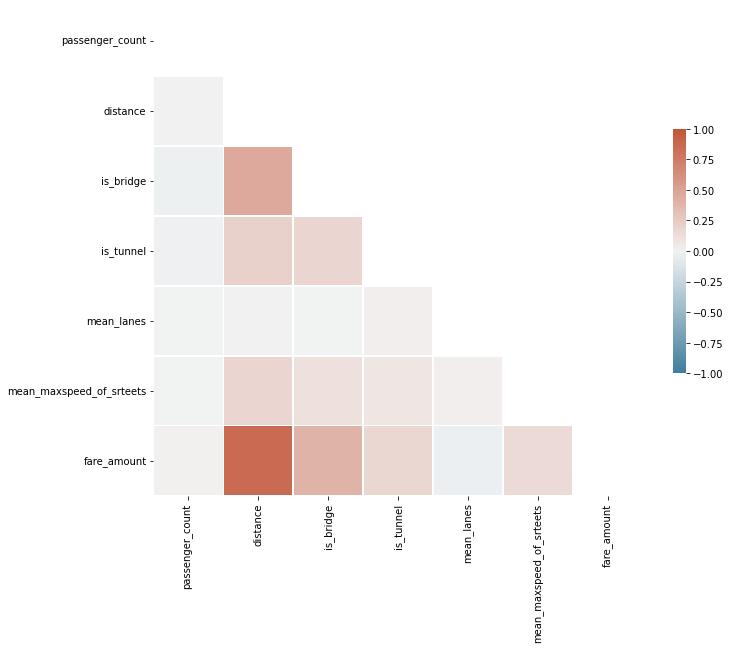

In [ ]:
# Compute the correlation matrix
corr = taxi_travels.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-1, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

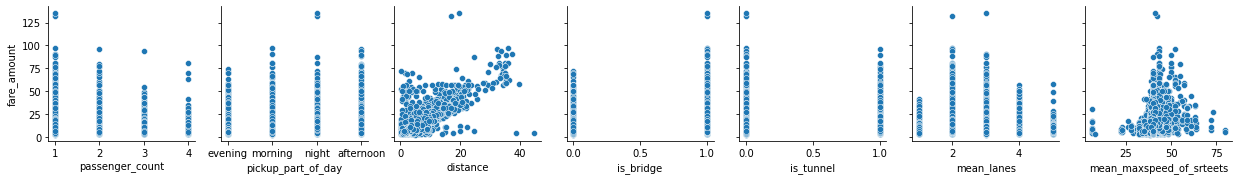

In [ ]:
sns.pairplot(data=taxi_travels, x_vars=['passenger_count', 'pickup_part_of_day',\
                                        'distance','is_bridge', 'is_tunnel', 'mean_lanes','mean_maxspeed_of_srteets'],\
                                y_vars=['fare_amount'])

# The Models

## Preparing and splitting the data

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score

from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree

from sklearn.neighbors import KNeighborsRegressor


In [ ]:
taxi_travels = pd.get_dummies(taxi_travels, columns=['pickup_part_of_day'])

In [ ]:
X = taxi_travels.drop('fare_amount', axis=1)
y = taxi_travels['fare_amount']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    train_size=0.75,
                                                    test_size=0.25,
                                                    random_state=0)

## Linear Regression model

In [ ]:
lr_model = LinearRegression().fit(X_train, y_train)
scores = -cross_val_score(lr_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
np.mean(scores)

10.172809576651009

In [ ]:
y_train_pred = lr_model.predict(X_train)
rms_train = mse(y_true=(y_train), y_pred=(y_train_pred), squared=False)
print('rms_train:', rms_train)

rms_train: 3.185919782973469


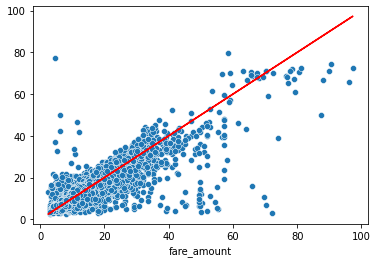

In [ ]:
ax = sns.scatterplot(x=y_train, y=y_train_pred)
ax.plot(y_train, y_train, 'r')

In [ ]:
y_test_pred = lr_model.predict(X_test)
rmse_test = mse(y_true=(y_test), y_pred=(y_test_pred), squared=False)
print('rms_test:', rmse_test)

rms_test: 3.6340989817577705


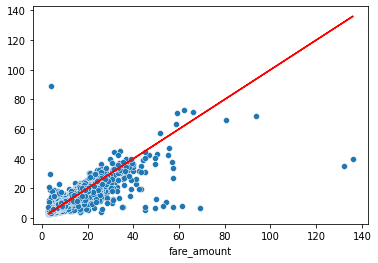

In [ ]:
ax = sns.scatterplot(x=y_test, y=y_test_pred)
ax.plot(y_test, y_test, 'r')

In [ ]:
# Mean Squared Error
#
print('MSE train: %.3f, test: %.3f' % (mse(y_train, y_train_pred),
                mse(y_test, y_test_pred)))
#
# R-Squared
#
print('R^2 train: %.3f, test: %.3f' % (r2_score(y_train, y_train_pred),
                r2_score(y_test, y_test_pred)))

MSE train: 10.150, test: 13.207
R^2 train: 0.763, test: 0.686


## Decision Tree Regression model

In [ ]:
dt_model = DecisionTreeRegressor()
# make a dictionary of hyperparameter values to search
param_grid = {
    'min_samples_leaf': [10,20,30],
    'ccp_alpha': [0.01,0.02,0.03],
    'max_leaf_nodes': [20,30,40,50],
    'max_depth': [4,5,6]
}

# make a GridSearchCV object
dt_model_gs = GridSearchCV(estimator = dt_model,
                  param_grid = param_grid,
                  scoring = ["r2", "neg_root_mean_squared_error"],
                  refit = "r2",
                  cv = 5)
dt_model_gs.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(),
             param_grid={'ccp_alpha': [0.01, 0.02, 0.03],
                         'max_depth': [4, 5, 6],
                         'max_leaf_nodes': [20, 30, 40, 50],
                         'min_samples_leaf': [10, 20, 30]},
             refit='r2', scoring=['r2', 'neg_root_mean_squared_error'])

In [ ]:
dt_model_gs_best = dt_model_gs.best_estimator_
dt_model_gs_best

DecisionTreeRegressor(ccp_alpha=0.01, max_depth=6, max_leaf_nodes=40,
                      min_samples_leaf=30)

In [ ]:
def visualize_tree(model, md=5, fs=(12, 8)):
    plt.figure(figsize=fs)
    plot_tree(model,
            max_depth=md,
            feature_names=model.feature_names_in_,
            label='all',
            filled=True,
            rounded=True,
            fontsize=12);

visualize_tree(dt_model_gs_best, md=7)

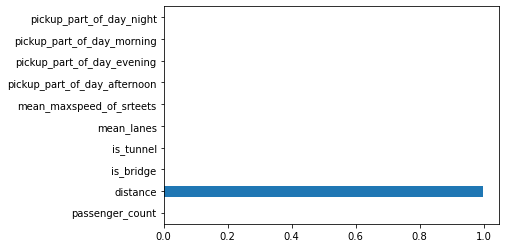

In [ ]:
pd.Series(dt_model_gs_best.feature_importances_, index=X.columns).plot.barh()

In [ ]:
scores = -cross_val_score(dt_model_gs_best, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
np.mean(scores)

10.628703968009749

In [ ]:
import math
math.sqrt(np.mean(scores))

3.2601693158499834

In [ ]:
y_train_pred = dt_model_gs_best.predict(X_train)
rms_train = mse(y_true=(y_train), y_pred=(y_train_pred), squared=False)
print('rms_train:', rms_train)

rms_train: 3.188439813212693


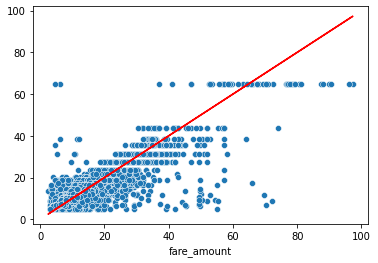

In [ ]:
ax = sns.scatterplot(x=y_train, y=y_train_pred)
ax.plot(y_train, y_train, 'r')

In [ ]:
y_test_pred = dt_model_gs_best.predict(X_test)
rmse_test = mse(y_true=(y_test), y_pred=(y_test_pred), squared=False)
print('rms_test:', rmse_test)

rms_test: 3.6136146352055043


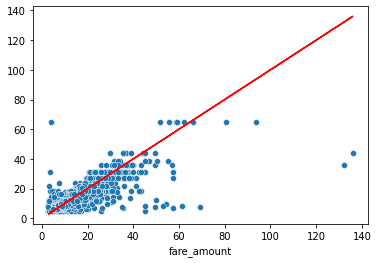

In [ ]:
ax = sns.scatterplot(x=y_test, y=y_test_pred)
ax.plot(y_test, y_test, 'r')

## K-Nearest Neighbors Regression model

In [ ]:
knn_model = KNeighborsRegressor()

param_grid = {
    'n_neighbors': [10,20,30],
    'metric': ['euclidean', 'manhattan', 'hamming']
}

# make a GridSearchCV object
knn_model_gs = GridSearchCV(estimator = knn_model,
                  param_grid = param_grid,
                  scoring = ["r2", "neg_root_mean_squared_error"],
                  refit = "r2",
                  cv = 5)

knn_model_gs.fit(X_train, y_train)


GridSearchCV(cv=5, estimator=KNeighborsRegressor(),
             param_grid={'metric': ['euclidean', 'manhattan', 'hamming'],
                         'n_neighbors': [10, 20, 30]},
             refit='r2', scoring=['r2', 'neg_root_mean_squared_error'])

In [ ]:
knn_model_gs_best = knn_model_gs.best_estimator_
knn_model_gs_best

KNeighborsRegressor(metric='manhattan', n_neighbors=30)

In [ ]:
scores = -cross_val_score(knn_model_gs_best, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
np.mean(scores)

10.39731842140868

In [ ]:
y_train_pred = knn_model_gs_best.predict(X_train)
rms_train = mse(y_true=(y_train), y_pred=(y_train_pred), squared=False)
print('rms_train:', rms_train)

rms_train: 3.1140353659797415


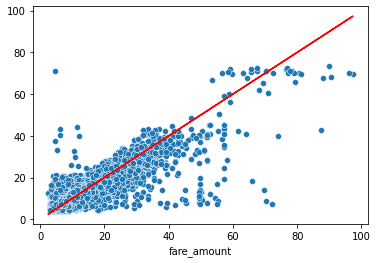

In [ ]:
ax = sns.scatterplot(x=y_train, y=y_train_pred)
ax.plot(y_train, y_train, 'r')

In [ ]:
y_test_pred = knn_model_gs_best.predict(X_test)
rmse_test = mse(y_true=(y_test), y_pred=(y_test_pred), squared=False)
print('rms_test:', rmse_test)

rms_test: 3.631303358552164


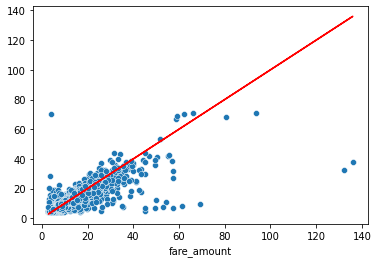

In [ ]:
ax = sns.scatterplot(x=y_test, y=y_test_pred)
ax.plot(y_test, y_test, 'r')

## XGBoost Regression model

In [ ]:
xgb_model = XGBRegressor()

param_grid = {
    "n_estimators" : [100, 200],
    "max_depth" : [3, 6, 9],
    "gamma" : [0.01, 0.02],
    "learning_rate" : [0.001, 0.01, 0.1, 1]
}

# make a GridSearchCV object
xgb_model_gs = GridSearchCV(estimator = xgb_model,
                  param_grid = param_grid,
                  scoring = ["r2", "neg_root_mean_squared_error"],
                  refit = "r2",
                  cv = 5,
                  verbose = 4)

xgb_model_gs.fit(X_train, y_train)

In [ ]:
xgb_model_gs_best = xgb_model_gs.best_estimator_
xgb_model_gs_best

XGBRegressor(gamma=0.01)

In [ ]:
scores = -cross_val_score(xgb_model_gs_best, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
np.mean(scores)

[12:18:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:18:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:18:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:18:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:18:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


10.356362758649285

In [ ]:
y_train_pred = xgb_model_gs_best.predict(X_train)
rms_train = mse(y_true=(y_train), y_pred=(y_train_pred), squared=False)
print('rms_train:', rms_train)

rms_train: 3.0033332907147128


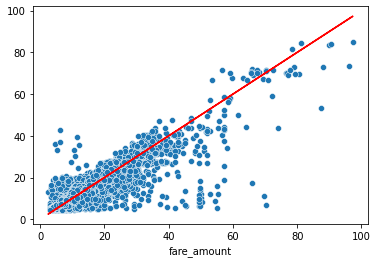

In [ ]:
ax = sns.scatterplot(x=y_train, y=y_train_pred)
ax.plot(y_train, y_train, 'r')

In [ ]:
y_test_pred = xgb_model_gs_best.predict(X_test)
rmse_test = mse(y_true=(y_test), y_pred=(y_test_pred), squared=False)
print('rms_test:', rmse_test)

rms_test: 3.578668047737029


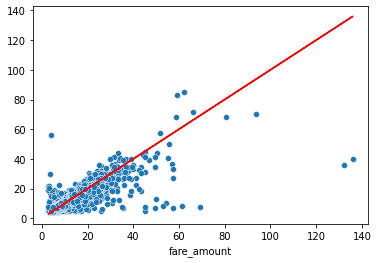

In [ ]:
ax = sns.scatterplot(x=y_test, y=y_test_pred)
ax.plot(y_test, y_test, 'r')